In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))])
trainset = torchvision.datasets.FashionMNIST(root="data",train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=2, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root="data",train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=2, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 273kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.98MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



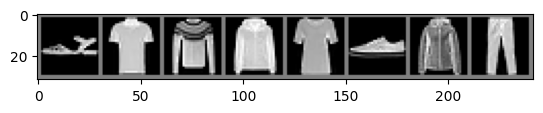

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the image
def imshow(img):
  img = img*0.5 + 0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
  # Plot some images
  imshow(torchvision.utils.make_grid(images[:8]))
  break

# **I. 256 Nodes**

### Model

In [5]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
model = model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)


In [6]:
# Generating a random tensor
input_tensor = torch.rand(5, 28, 28).to(device)

# Feeding the tensor into the model
output = model(input_tensor)
print(output.shape)

torch.Size([5, 10])


### Loss, Optimizer, and Activation Function

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [8]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
  model.eval()
  test_loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for images, labels in testloader:
      # Move inputs, labels to the device
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [9]:
test_loss, test_accuracy = evaluate(model, testloader, criterion)
print(f'test_loss: {test_loss}')
print(f'test_accuracy: {test_accuracy}')

test_loss: 2.310782289505005
test_accuracy: 12.19


### Train

In [10]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 400

In [11]:
# train
for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/400], Loss: 1.8179, Accuracy: 49.05%, Test Loss: 1.4369, Test Accuracy: 65.09%
Epoch [2/400], Loss: 1.2183, Accuracy: 69.72%, Test Loss: 1.0620, Test Accuracy: 71.12%
Epoch [3/400], Loss: 0.9615, Accuracy: 72.64%, Test Loss: 0.8971, Test Accuracy: 72.89%
Epoch [4/400], Loss: 0.8390, Accuracy: 73.97%, Test Loss: 0.8101, Test Accuracy: 73.98%
Epoch [5/400], Loss: 0.7688, Accuracy: 75.03%, Test Loss: 0.7562, Test Accuracy: 75.01%
Epoch [6/400], Loss: 0.7225, Accuracy: 75.89%, Test Loss: 0.7194, Test Accuracy: 75.74%
Epoch [7/400], Loss: 0.6896, Accuracy: 76.56%, Test Loss: 0.6916, Test Accuracy: 76.21%
Epoch [8/400], Loss: 0.6641, Accuracy: 77.17%, Test Loss: 0.6693, Test Accuracy: 76.65%
Epoch [9/400], Loss: 0.6432, Accuracy: 77.73%, Test Loss: 0.6512, Test Accuracy: 77.19%
Epoch [10/400], Loss: 0.6257, Accuracy: 78.23%, Test Loss: 0.6357, Test Accuracy: 77.64%
Epoch [11/400], Loss: 0.6108, Accuracy: 78.78%, Test Loss: 0.6222, Test Accuracy: 78.22%
Epoch [12/400], Loss: 0.5977, 

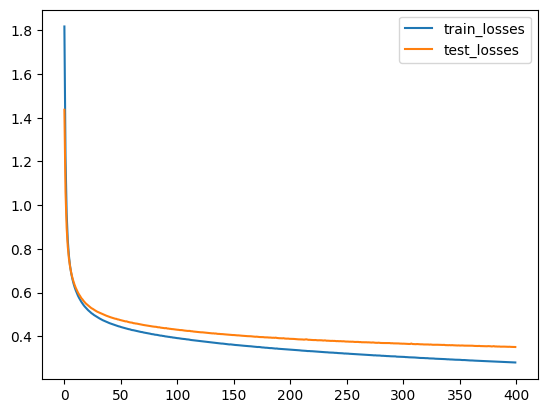

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

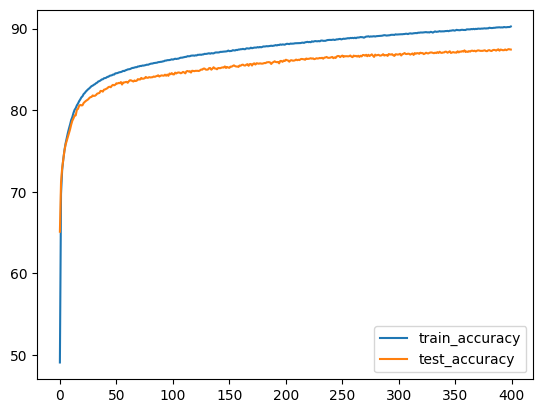

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()